# Machine Learning

The data collected is a time series. Therefore, for the machine learning section different models will be built for the purpose of predicting how many accidents are going to occur in the next hour given traffic data from the past and weather estimatations for that next hour. Since we naturally have access to future weather predictions, I wanted to incorporate this into my model, and this was the reason for using the future weather as a feature. Since I am using time series data, I will only be predicting accidents for one specific location rather than at multiple locations. The analysis that was done in the data exploration section suggests that postmile 55.89 appears to have the most variability and impact in regards to accidents. Therefore, I will be using this specific postmile and the associated data for my predictions.

One forseeable problem that was breifly discussed in the data exploration was the time distortion in my data. The data is represented by hours in a day; however, these hours are averaged throughout an entire week. This will most likely cause problems for the models that I will be implementing.

In [1]:
%matplotlib
import pandas as pd
import numpy as np
pd.options.display.max_rows=10

Using matplotlib backend: Qt5Agg


# Load Datasets

The data exploration suggested that the weather categories do not necessarily hold any useful information; therefore, only temperature and windspeed will be used for the weather conditions. Also, since the model will be tested by time step (explained later), rather than having a separate test set, only one set is necessary.

In [2]:
traffic_train = pd.read_csv('Traffic_Data/Traffic_Data_Train')
traffic_test = pd.read_csv('Traffic_Data/Traffic_Data_Test')
traffic_df = pd.concat([traffic_train, traffic_test], ignore_index=True)

# drop weather categories
traffic_df = traffic_df.iloc[:, :11]
traffic_df

,Time,Postmile (Abs),Speed,Week,Flow,Occupancy,Truck Flow,Miles Traveled (Mean),Accidents,Temperature,Windspeed
0,0:00,53.02,69.17,1,1634,0.03,155,581738800,0.0,48.833333,2.333333
1,0:00,53.75,67.55,1,1646,0.03,63,581738800,0.0,48.833333,2.333333
2,0:00,54.06,67.82,1,1584,0.05,3,581738800,0.0,48.833333,2.333333
3,0:00,54.55,71.10,1,1671,0.02,235,581738800,0.0,48.833333,2.333333
4,0:00,54.87,65.68,1,1590,0.04,272,581738800,0.0,48.833333,2.333333
...,...,...,...,...,...,...,...,...,...,...,...
15043,23:00,55.31,65.42,57,2541,0.05,81,658290165,0.0,47.000000,1.500000
15044,23:00,55.89,66.72,57,3294,0.10,943,658290165,0.0,47.000000,1.500000
15045,23:00,56.97,68.26,57,1405,0.02,27,658290165,0.0,47.000000,1.500000
15046,23:00,57.80,68.30,57,1872,0.04,280,658290165,0.0,47.000000,1.500000


# Preprocessing

The data needs to be separated by postmile

In [3]:
def separate_postmiles(df):
    postmiles = []
    
    # iterate through posmiles and extract
    for postmile in df['Postmile (Abs)'].unique():
        postmiles.append(df.loc[
            df['Postmile (Abs)'] == postmile]
                         .reset_index(drop=True))
    return postmiles

In [4]:
postmiles_df = separate_postmiles(traffic_df)

In [5]:
postmiles_df[0].shape

(1368, 11)

**Seaparate Postmiles**

Separate the features that will be used as the past from those <br>
that will be used from the future in order to convert the data <br>
into an appropriate time series. 

In [6]:
past_features = traffic_df.columns[:9]
past_features

Index(['Time', 'Postmile (Abs)', 'Speed', 'Week', 'Flow', 'Occupancy',
       'Truck Flow', 'Miles Traveled (Mean)', 'Accidents'],
      dtype='object')

In [7]:
future_features = traffic_df.columns[9:]
future_features

Index(['Temperature', 'Windspeed'], dtype='object')

**Time Series Conversion**

In order to convert my data into a time series, the label has to be a future event. <br>
Therefore, the data has to be shifted by one, where the traffic features occur at time <br>
(t) and the number of accidents (label) occur at time (t+1). The number of accidents <br>
that occured at time (t) is also going to be used; therefore, the accidents column has <br>
to be copied before shifting. Since the future weather is going to be used, it also needs <br>
to be occuring at time (t+1). This method below implements this conversion.

In [8]:
def convert_to_time_series(df, label, future_features, past_features):
    
    # preserve current label value
    future_label = str(label) + ' (t+1)'
    df[future_label] = df[label]
    
    # inpute sequence (time t+1)
    df[future_features] = df[future_features].shift(-1)
    df[future_label] = df[future_label].shift(-1)
    
    # change column names
    past_names = [name + ' (t)' for name in past_features.values]
    future_names = [name + ' (t+1)' for name in future_features.values]
    future_names.append(future_label)
    df.columns = np.append(past_names, future_names)
    return df

In [9]:
def convert_each_postmile(df, label):
    for postmile in df:
        postmile = convert_to_time_series(postmile,
                                          label,
                                          future_features,
                                          past_features)
        # these feautures are not needed
        postmile.drop(['Time (t)', 'Week (t)', 'Postmile (Abs) (t)'], axis=1, inplace=True)
        postmile.dropna(inplace=True)
    return df

In [10]:
postmiles_df = convert_each_postmile(postmiles_df, 'Accidents')

Only postmile 55.89 is going to be used

In [11]:
traffic_df['Postmile (Abs)'].unique()

array([53.02, 53.75, 54.06, 54.55, 54.87, 54.99, 55.31, 55.89, 56.97,
       57.8 , 57.86])

In [12]:
postmile_df = postmiles_df[7]

In [13]:
traffic_df.loc[traffic_df['Postmile (Abs)'] == 55.89].head()

,Time,Postmile (Abs),Speed,Week,Flow,Occupancy,Truck Flow,Miles Traveled (Mean),Accidents,Temperature,Windspeed
7,0:00,55.89,68.07,1,4199,0.11,1528,581738800,0.0,48.833333,2.333333
18,1:00,55.89,67.88,1,3754,0.11,1490,473978751,0.0,49.000000,1.666667
29,2:00,55.89,67.00,1,3555,0.11,1461,404709163,1.0,47.833333,1.333333
40,3:00,55.89,67.83,1,3776,0.11,1484,430204301,0.0,44.666667,0.000000
51,4:00,55.89,69.07,1,4476,0.12,1551,703978875,0.0,44.166667,1.000000


In [14]:
postmile_df.head()

,Speed (t),Flow (t),Occupancy (t),Truck Flow (t),Miles Traveled (Mean) (t),Accidents (t),Temperature (t+1),Windspeed (t+1),Accidents (t+1)
0,68.07,4199,0.11,1528,581738800,0.0,49.000000,1.666667,0.0
1,67.88,3754,0.11,1490,473978751,0.0,47.833333,1.333333,1.0
2,67.00,3555,0.11,1461,404709163,1.0,44.666667,0.000000,0.0
3,67.83,3776,0.11,1484,430204301,0.0,44.166667,1.000000,0.0
4,69.07,4476,0.12,1551,703978875,0.0,43.833333,0.500000,0.0


# Setup

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

**Backtesting (Rolling-Window Analysis)**

Since the data is a time series, using cross validation is not advisable. The problem with cross validation is that it randomly selects a subset of the data. This suggests that the future values are going to be used to predict the past. Therefore, backtesting has to be implemented. Backtesting (Rolling-Window analysis) is a process where the first n examples are used to train a model, the model then makes a prediction for the next time step, then the number of examples is increased (the window is expanded) to include the ground truth value for the previous predicted time step, and the process is repeated. This allows for the proper evaluation of the model. This is the reason for having only one DataFrame with all the examples. The RMSE is then calculated from the predicted and ground truth values.

Note: <br>
Since a separate model has to be fitted and trained for each predicted time step, the models below <br>
will be doing mult-step forecasting, where they are going to be predicting multiple future time <br>
steps rather than just one. This is simply for time convenience

In [16]:
def prepare_test(df, label):
    X = np.asarray(df.drop([label], axis=1).astype(float))
    y = df[[label]].squeeze()
    
    # Feature Scaling
    sc = StandardScaler()
    X_SC = sc.fit_transform(X)
    
    return X_SC, y

In [17]:
def run_model(model, df, label, n_hours, default=True, dim=False):
    
    # Create Training and Validation sets
    X = np.asarray(df.drop([label], axis=1).astype(float))
    y = df[[label]].squeeze()
    
    # backtesting
    mse,model = backtest(model, X, y, n_hours, default, dim)
    
    print("RMSE: ", np.sqrt(mse))
    return model

In [18]:
def backtest(model, X, y, n_hours, default=True, dim=False):
    y_pred = []
    y_true = []

    # time steps
    steps=12
    
    # n hours represents the amount of hours 
    # that are going to be predicted
    for hours in reversed(range(1,n_hours,steps)):
        
        # select the data before the hour that 
        # the model is predicting for
        X_train = X[:len(X)-hours]
        y_train = y[:len(y)-hours]
        
        # select the data from the hour
        # to the number of steps that are going to 
        # be predicted concurrently
        X_val = X[len(X)-hours:len(X)-hours+steps]
        y_val = y[len(y)-hours:len(y)-hours+steps]
        
        # Feature Scaling
        sc = StandardScaler()
        X_trainSC = sc.fit_transform(X_train)
        X_valSC = sc.transform(X_val)
        
        if default:
            # Baseline implemenation
            model.fit(X_trainSC, y_train)
            y_pred.extend(model.predict(X_valSC))
        else:
            # RNN
            pred, model = run_network(model, X_trainSC, y_train, X_valSC, dim)
            y_pred.extend(pred.flatten())
        
        # add ground truth values
        y_true.extend(y_val)
        
    # save to history
    global pred_history, true_history
    pred_history = y_pred
    true_history = y_true
        
    return mean_squared_error(y_true, y_pred), model

In [19]:
def run_network(model, X_train, y_train, X_val, dim=False):
    n_steps = 1
    n_features = X_train.shape[1]
    
    if dim:
        # extra dimension is needed for TimeDistributed layer
        X_train = X_train.reshape(X_train.shape[0], n_steps, n_features, 1)
        X_val = X_val.reshape(X_val.shape[0], n_steps, n_features, 1)
    else:
        X_train = X_train.reshape(X_train.shape[0], n_steps, n_features)
        X_val = X_val.reshape(X_val.shape[0], n_steps, n_features)
        
    model.fit(X_train,
              y_train,
              batch_size=512,
              epochs=100,
              verbose=False)
    return model.predict(X_val), model

In [20]:
def save_history():
    global pred_history, true_history
    
    df = pd.DataFrame(np.transpose([pred_history, true_history]))
    df.columns=['pred', 'true']
    
    # erase history
    pred_hisotry = None
    true_history = None
    
    return df

# BaseLine Models

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

In [22]:
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from keras.layers import LSTM, GRU, Dense, Dropout, TimeDistributed, average, concatenate
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [23]:
label = 'Accidents (t+1)'
n_hours = postmile_df.shape[0]-(24*38)

In [24]:
pred_history = None
true_history = None

A series of baselines models were implemented but not necessarily fine tuned. <br>
I focused most of my efforts on the last model.

# LR

In [25]:
lr_model = LinearRegression()
lr_model = run_model(lr_model, postmile_df, label, n_hours)

RMSE:  0.2959527802076873


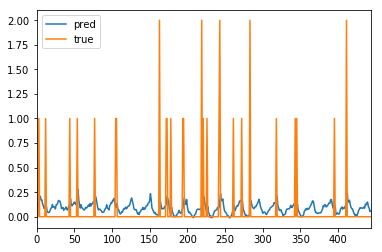

In [26]:
lr_history = save_history()
lr_history.plot.line()

# SVR_LINEAR

In [27]:
svr_linear_model = SVR(kernel='linear', gamma='auto')
svr_linear_model = run_model(svr_linear_model, postmile_df, label, n_hours)

RMSE:  0.29698846860122197


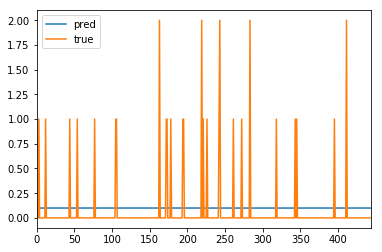

In [28]:
svr_linear_history = save_history()
svr_linear_history.plot.line()

# SVR_RBF

In [29]:
svr_rbf_model = SVR(gamma='auto')
svr_rbf_model = run_model(svr_rbf_model, postmile_df, label, n_hours)

RMSE:  0.2973684273819893


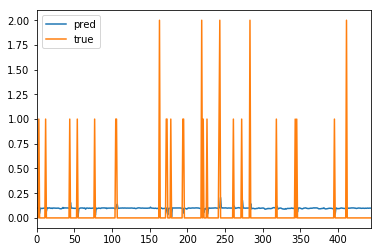

In [30]:
svr_rbf_history = save_history()
svr_rbf_history.plot.line()

# SVR_POLY

In [31]:
svr_poly_model = SVR(kernel='poly', gamma='auto')
svr_poly_model = run_model(svr_poly_model, postmile_df, label, n_hours)

RMSE:  0.296801038897141


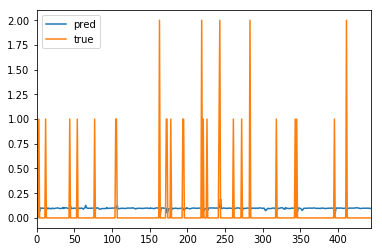

In [32]:
svr_poly_history = save_history()
svr_poly_history.plot.line()

# RIDGE

In [33]:
ridge_model = Ridge()
ridge_model = run_model(ridge_model, postmile_df, label, n_hours)

RMSE:  0.2958652715447477


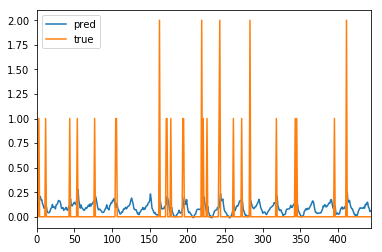

In [34]:
ridge_history = save_history()
ridge_history.plot.line()

# RFR

In [35]:
rfr_model = RandomForestRegressor(n_estimators=100)
rfr_model = run_model(rfr_model, postmile_df, label, n_hours)

RMSE:  0.3115517523334165


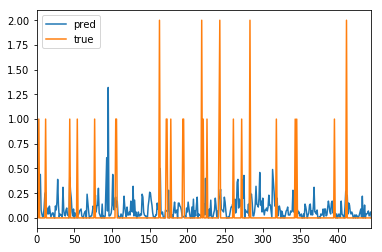

In [36]:
rfr_history = save_history()
rfr_history.plot.line()

# CNN_1

In [37]:
n_steps = 1
n_features = postmile_df.shape[1]-1

In [38]:
inputs = Input(shape=(n_steps, n_features))
x = Conv1D(64, 1, activation='relu')(inputs)
x = MaxPooling1D(1)(x)
x = Flatten()(x)
x = Dense(50,activation='relu')(x)
outputs = Dense(1, activation='linear')(x)
cnn_model_1 = Model(inputs=inputs, outputs = outputs)

cnn_model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 8)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             576       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3250      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 3,877
Trainable params: 3,877
Non-trainable params: 0
_________________________________________________________________


In [39]:
cnn_model_1.compile(optimizer='adam', loss='mse')
cnn_model_1 = run_model(cnn_model_1, 
                        postmile_df, 
                        label, n_hours, default=False)

RMSE:  0.46309750837255115


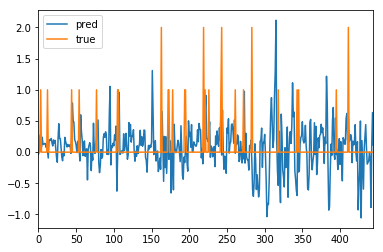

In [40]:
cnn_1_history = save_history()
cnn_1_history.plot.line()

# CNN_2

In [41]:
inputs = Input(shape=(n_steps, n_features))
x = Conv1D(128, 1, activation='relu')(inputs)
x = MaxPooling1D(1)(x)
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='linear')(x)
cnn_model_2 = Model(inputs=inputs, outputs = outputs)

cnn_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 8)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 128)            1152      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total para

In [42]:
cnn_model_2.compile(optimizer='RMSprop', loss='mse')
cnn_model_2 = run_model(cnn_model_2, 
                        postmile_df, 
                        label, n_hours, default=False)

RMSE:  0.3896295518125137


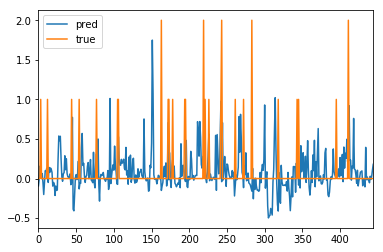

In [43]:
cnn_2_history = save_history()
cnn_2_history.plot.line()

# LSTM_1

In [43]:
inputs = Input(shape=(n_steps, n_features))
x = LSTM(50)(inputs)
outputs = Dense(1, activation='linear')(x)
lstm_1_model = Model(inputs=inputs, outputs=outputs)
lstm_1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


In [44]:
lstm_1_model.compile(optimizer='RMSprop', loss='mse')
lstm_1_model = run_model(lstm_1_model, 
                         postmile_df, 
                         label, n_hours, default=False)

RMSE:  0.3181474513392005


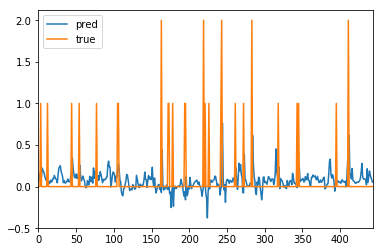

In [45]:
lstm_1_history = save_history()
lstm_1_history.plot.line()

# LSTM_2

In [46]:
inputs = Input(shape=(n_steps, n_features))
x = LSTM(128, activation='relu', return_sequences=True)(inputs)
x = Dropout(0.2)(x)

x = LSTM(128, activation='relu')(x)
x = Dropout(0.1)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='linear')(x)
lstm_model_2 = Model(inputs=inputs, outputs=outputs)
lstm_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 8)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 128)            70144     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

In [47]:
lstm_model_2.compile(optimizer='adam', loss='mse')
lstm_model_2 = run_model(lstm_model_2, 
                         postmile_df, 
                         label, n_hours, default=False)

RMSE:  0.3196277130624804


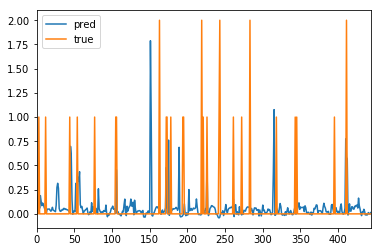

In [48]:
lstm_2_history = save_history()
lstm_2_history.plot.line()

# GRU

In [49]:
inputs = Input(shape=(n_steps, n_features))
x = GRU(128, activation='relu', return_sequences=True)(inputs)
x = Dropout(0.15)(x)

x = GRU(128, activation='relu')(x)
x = Dropout(0.15)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(.1)(x)

outputs = Dense(1, activation='linear')(x)
gru_model = Model(inputs=inputs, outputs=outputs)
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1, 8)              0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1, 128)            52608     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
__________

In [50]:
gru_model.compile(optimizer='RMSprop', loss='mse')
gru_model = run_model(gru_model, 
                      postmile_df, 
                      label, n_hours, default=False)

RMSE:  0.30722330985785595


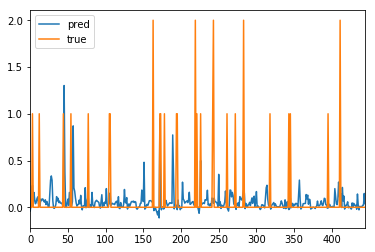

In [51]:
gru_history = save_history()
gru_history.plot.line()

# CNN-LSTM

In [52]:
inputs = Input(shape=(n_steps, n_features))
#cnn
x = Conv1D(64, 1, activation='relu')(inputs)
x = MaxPooling1D(1)(x)

#LSTM
x = LSTM(128, activation='relu', return_sequences=True)(x)
x = Dropout(0.2)(x)

x = LSTM(128, activation='relu')(x)
x = Dropout(0.1)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='linear')(x)
cnn_lstm_model = Model(inputs=inputs, outputs = outputs)

cnn_lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1, 8)              0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 64)             576       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 128)            98816     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

In [53]:
cnn_lstm_model.compile(optimizer='RMSprop', loss='mse')
cnn_lstm_model = run_model(cnn_lstm_model, 
                           postmile_df, 
                           label, n_hours, default=False)

RMSE:  0.32857486348939047


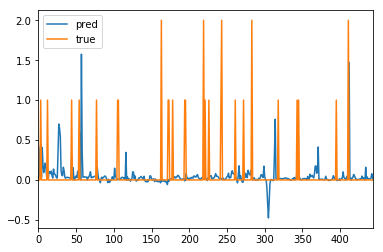

In [54]:
cnn_lstm_history = save_history()
cnn_lstm_history.plot.line()

# CNN-GRU_1

In [55]:
inputs = Input(shape=(n_steps, n_features))
#cnn
x = Conv1D(64, 1, activation='relu')(inputs)
x = MaxPooling1D(1)(x)

#LSTM
x = GRU(128, activation='relu', return_sequences=True)(x)
x = Dropout(0.2)(x)

x = GRU(128, activation='relu')(x)
x = Dropout(0.1)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='linear')(x)
cnn_gru_1_model = Model(inputs=inputs, outputs = outputs)

cnn_gru_1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 1, 8)              0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 64)             576       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
gru_3 (GRU)                  (None, 1, 128)            74112     
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
__________

In [56]:
cnn_gru_1_model.compile(optimizer='RMSprop', loss='mse')
cnn_gru_1_model = run_model(cnn_gru_1_model, 
                            postmile_df, 
                            label, n_hours, default=False)

RMSE:  0.32471306525534904


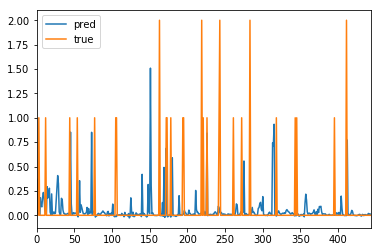

In [57]:
cnn_gru_1_history = save_history()
cnn_gru_1_history.plot.line()

# CNN-GRU_2

In [58]:
inputs = Input(shape=(n_steps, n_features, 1))
#cnn
x = TimeDistributed(Conv1D(128, 1, activation='relu'))(inputs)
x = TimeDistributed(MaxPooling1D(1))(x)
x = TimeDistributed(Flatten())(x)

#GRU
x = GRU(128, activation='relu', return_sequences=True)(x)
x = Dropout(0.2)(x)
x = GRU(128, activation='relu', return_sequences=True)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='linear')(x)
cnn_gru_2_model = Model(inputs=inputs, outputs = outputs)

cnn_gru_2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 1, 8, 1)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 8, 128)         256       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 8, 128)         0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 1024)           0         
_________________________________________________________________
gru_5 (GRU)                  (None, 1, 128)            442752    
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
gru_6 (GRU)                  (None, 1, 128)            98688     
__________

In [59]:
cnn_gru_2_model.compile(optimizer='RMSprop', loss='mse')
cnn_gru_2_model = run_model(cnn_gru_2_model, 
                            postmile_df, 
                            label, n_hours, default=False, dim=True)

RMSE:  0.3532502726754906


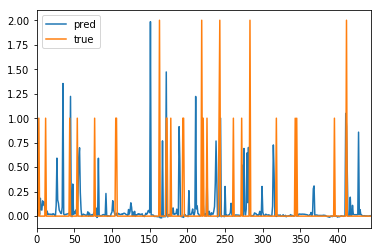

In [60]:
cnn_gru_2_history = save_history()
cnn_gru_2_history.plot.line()

# HMDLF

Most of my efforts were spent implementing and tuning this model as I believed it would be a good learning experience. This model is a mutlimodal network that utilizes both LSTMs as well as CNNs. The LSTM allows the modal to capture any temporal relationships, such as going from one hour to the next. The CNN allows it to capture any spatial relationships such as those seen with vehicle speed and traffic flow. This network was purposed and used for a very similar task, that of predicting traffic flow. Below is the link to the research paper for more details. I wanted to see if such network was able to translate to predicting how many accidents would occur as well as if it could deal with the time distortion problem mentioned in the beginning of this section.

A Hybrid Method for Traffic Flow Forecasting Using Multimodal Deep Learning: <br>
https://arxiv.org/pdf/1803.02099.pdf

In [61]:
modalities = []
diff_inputs = []

# split dataframe by feature
# each feature will be its own network and then
# all the models will be joined to form one mulitmodal
# network
for features in postmile_df.iloc[:, :8].columns:
    inputs = Input(shape=(n_steps, 1, 1))
    
    #cnn
    x = TimeDistributed(Conv1D(64, 1, activation='relu'))(inputs)
    x = TimeDistributed(MaxPooling1D(1))(x)
    x = TimeDistributed(Flatten())(x)

    # LSTM is used instead of GRU
    x = LSTM(128, activation='relu', return_sequences=True)(x)
    x = LSTM(128, activation='relu', return_sequences=True)(x)
    x = Flatten()(x)

    modalities.append(x)
    diff_inputs.append(inputs)

# joint the networks
multimodal = concatenate(modalities)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='linear')(x)

# final model
hybrid = Model(inputs=diff_inputs, outputs=outputs)

In [62]:
# Different testing method due to the modalities
def test_multiModal(model, X, y):
    y_pred = []
    y_true = []
    
    # prevent errors
    X = X.astype(float)

    # time steps
    steps=12
    
    # n_hours represents the amount of hours
    # that are goint to be predicted
    sc = StandardScaler()
    for hours in reversed(range(1,n_hours,steps)):
        
        # select the data before the hour that 
        # the model is predicting for
        X_train = X[:len(X)-hours]
        y_train = y[:len(y)-hours]
        
        # select the data from the hour
        # to the number of steps that are going to 
        # be predicted concurrently
        X_val = X[len(X)-hours:len(X)-hours+steps]
        y_val = y[len(y)-hours:len(y)-hours+steps]
              
        # Feature Scaling
        X_trainSC = sc.fit_transform(X_train)
        X_valSC = sc.transform(X_val)
        
        # Dimensions
        n_examples = X_train.shape[0]
        n_steps = 1
        n_features = X_train.shape[1]
        
        # split dataframe by features
        X_train_modalities = split_DataFrame(pd.DataFrame(X_train))
        X_val_modalities = split_DataFrame(pd.DataFrame(X_val))
        
        # use all the modalities as the input
        model.fit(X_train_modalities,
                  y_train,
                  batch_size=512,
                  epochs=100,
                  verbose=False)

        y_pred.extend(model.predict(X_val_modalities).flatten())
        y_true.extend(y_val)
    
    # save to history
    global pred_history, true_history
    pred_history = y_pred
    true_history = y_true
    
    print('RMSE: ', np.sqrt(mean_squared_error(y_true, y_pred)))
    return model

In [63]:
def split_DataFrame(df):
    series_list = []
    
    # make each feature a separate list
    for feature in df.columns:
        temp = np.asarray(df[feature])
        
        # add needed dimensions for the network
        temp = temp.reshape(temp.shape[0],1,1,1)
        series_list.append(temp)
        
    return series_list

In [64]:
hybrid.compile(optimizer='RMSprop', loss='mse')
hybrid = test_multiModal(hybrid, postmile_df.iloc[:, :8], postmile_df.iloc[:, -1])

RMSE:  0.2966798005139237


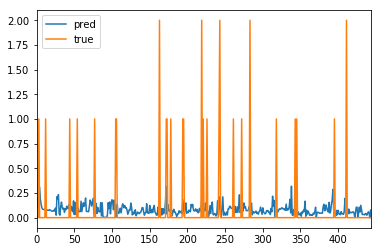

In [65]:
hmdlf_model = save_history()
hmdlf_model.plot.line()

# HMLDF For Traffic Flow

This model does not seem to be useful. In order to understand if the problem is the actual model itself or if its predicting accidents, it will be translated to predicting Flow as suggested in the research paper mentioned above.

In [66]:
# redo preprocessing steps to predict Flow
postmiles_df2 = separate_postmiles(traffic_df)
postmiles_df2 = convert_each_postmile(postmiles_df2, 'Flow')
postmile_df2 = postmiles_df2[7]

In [67]:
postmile_df2.head()

,Speed (t),Flow (t),Occupancy (t),Truck Flow (t),Miles Traveled (Mean) (t),Accidents (t),Temperature (t+1),Windspeed (t+1),Flow (t+1)
0,68.07,4199,0.11,1528,581738800,0.0,49.000000,1.666667,3754.0
1,67.88,3754,0.11,1490,473978751,0.0,47.833333,1.333333,3555.0
2,67.00,3555,0.11,1461,404709163,1.0,44.666667,0.000000,3776.0
3,67.83,3776,0.11,1484,430204301,0.0,44.166667,1.000000,4476.0
4,69.07,4476,0.12,1551,703978875,0.0,43.833333,0.500000,5714.0


In [68]:
modalities = []
diff_inputs = []

# only use the flow, speed, and occupancy as features
for features in postmile_df2.iloc[:, :3].columns:
    inputs = Input(shape=(n_steps, 1, 1))
    
    #cnn
    x = TimeDistributed(Conv1D(32, 1, activation='relu'))(inputs)
    x = TimeDistributed(MaxPooling1D(1))(x)
    x = TimeDistributed(Flatten())(x)

    #GRU
    x = LSTM(128, activation='relu', return_sequences=True)(x)
    x = Dropout(0.1)(x)
    x = LSTM(128, activation='relu', return_sequences=True)(x)
    x = Dropout(0.1)(x)
    x = Flatten()(x)

    modalities.append(x)
    diff_inputs.append(inputs)
    
multimodal = concatenate(modalities)
x = Dense(64, activation='relu')(multimodal)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(multimodal)
x = Dropout(0.1)(x)

outputs = Dense(1, activation='linear')(x)
hybrid_flow = Model(inputs=diff_inputs, outputs=outputs)

In [70]:
hybrid_flow.compile(optimizer='RMSprop', loss='mse')
hybrid_flow = test_multiModal(hybrid_flow, postmile_df2.iloc[:, :3], postmile_df2.iloc[:, -1])

RMSE:  832.18826850593


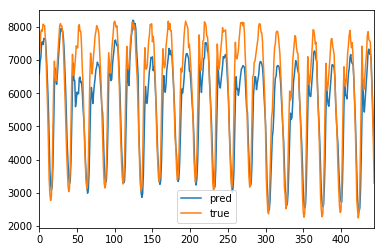

In [71]:
hmdlf_model = save_history()
hmdlf_model.plot.line()

The model above was not tuned, but still seems to learn the patterns associated with traffic flow. For this reason, I believe that the time distortion in my data is the main problem for trying to predict accidents. Also predicting multiple time steps rather than one, is another factor that may have impacted my results.

# Analysis

The HMDLF model doesn't do too well for predicting future accidents for my data. There are two specific reasons that I believe are preventing the model from learning. The first reason is simply due to the fact that the features alone are not useful for prediciting accidents. There is no correlation between any of the features and accidents as examined in the Data Exploration section. The essential problem, and my second reason for why this is not working, is the time distortion. The features that are used here are most likely very influential in deciding if an accident is going to occur, however only at the exact times before these accidents occur. The data that I was able to collect are weekly averages, and this is most likely the core of the problem.

Overall the CNN_GRU appears to be the model with the most potential and learning the most, from the graph displayed, even though it recieved a higher RMSE. The CNN_GRU was a baseline implemenation, and most likely can be tuned to perform much better. However, I wanted to focus most of my efforts imlementing the HMLDF model, as I wanted to explore some of its characteristics. Overall, the project was a great learing experience.

Note: <br>
Professor Sun, the quarter was great and learning how to work with Pandas was extremeley helpful. Thank you and I appreciate all the time you put into the course.